## 00. 환경설정

In [1]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

import gensim
import warnings
warnings.filterwarnings("ignore")

C:\Users\kimminsu\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 01. Item2Vec을 이용한 추천시스템 구현
- Item2Vec에 가장 적합한 데이터는 유저 혹은 세션 단위로 비슷한 의도를 가지고 아이템을 소비한 로그 데이터입니다.
- 무비렌즈 데이터는 Item2Vec을 수행하기에 적합한 데이터는 아니지만 Item2Vec을 통한 연관 추천의 결과가 잘 드러납니다.

In [2]:
movies_df = pd.read_csv("../data/ml-latest-small/movies.csv")
ratings_df = pd.read_csv("../data/ml-latest-small/ratings.csv")

movie_id_to_name = pd.Series(movies_df.title.values, index = movies_df.movieId.values).to_dict()
name_to_movie_id = pd.Series(movies_df.movieId.values, index = movies_df.title).to_dict()

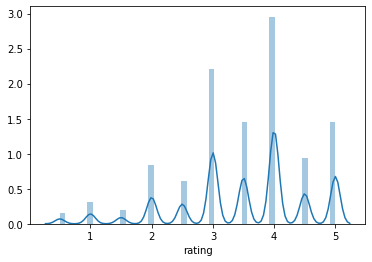

In [3]:
sns.distplot(ratings_df['rating'])

In [4]:
from sklearn.model_selection import train_test_split

ratings_df['liked'] = np.where(ratings_df['rating'] >= 4, 1, 0)
ratings_df['movieId'] = ratings_df['movieId'].astype("str")
train_df, test_df = train_test_split(ratings_df, stratify = ratings_df['userId'], random_state=100, test_size=0.2)

In [5]:
train_df

,userId,movieId,rating,timestamp,liked
78097,484,3911,4.0,1342294787,1
34543,232,48877,3.5,1163024515,0
94410,599,26940,2.5,1519346264,0
85385,555,724,5.0,978745225,1
78341,487,31658,3.5,1428574498,0
...,...,...,...,...,...
79624,495,7163,4.5,1458636189,1
57080,380,1544,4.0,1493667555,1
56692,377,1262,4.5,1340341828,1
96597,603,2118,3.0,953925630,0


In [6]:
print("number of train data:", len(train_df))
print("number of test  data:", len(test_df))

number of train data: 80668
number of test  data: 20168


#### 한 명의 유저를 기준으로 4점 이상으로 평가한 영화와 4점 미만으로 평가한 영화를 나누어 각각 Item2Vec 임베딩에 사용합니다.

In [7]:
user_grouped = train_df.groupby(['liked', 'userId'])
user_movie_list = [user_grouped.get_group(gp)['movieId'].tolist() for gp in user_grouped.groups]

#### 0번 유저의 학습 데이터

In [8]:
user_movie_list[0]

['673',
 '3176',
 '423',
 '223',
 '70',
 '2617',
 '2414',
 '1219',
 '2338',
 '2253',
 '2389',
 '3243',
 '1445',
 '1644',
 '2528',
 '3247',
 '1408',
 '1030',
 '500',
 '2093',
 '1676',
 '1377',
 '736',
 '316']

In [9]:
len(user_movie_list)

1215

### Gensim의 [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)
- Gensim 패키지는 Word2Vec 임베딩을 제공합니다.

In [10]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(sentences = user_movie_list,
                 epochs = 5,
                 vector_size = 100,
                 min_count = 3,     # 단어가 최소 3회 이상 등장해야 학습되고 모델에 저장됨 
                 workers = 4,
                 sg = 1,            # skip-gram을 사용한다면 1
                 hs = 0,            # negative sampling을 사용한다면 0 (hierarchical softmax)
                 negative = 5,      # 1개의 positive sample 당 negative sample의 개수
                 window = 9999999   # Window를 크게 잡는 이유는 문장 내 모든 아이템끼리 학습이 되어야 하기 때문
                )

word_vectors = model.wv

#### 임베딩된 아이템의 결과

In [11]:
word_vectors['30793']

array([-0.03946853,  0.00545489,  0.27740222,  0.18820502,  0.01148834,
        0.20195721, -0.02110451,  0.05552216,  0.07477687, -0.09445705,
        0.06600963,  0.01623284, -0.15554582, -0.02479254,  0.2111969 ,
        0.15701886, -0.1652993 , -0.22461776, -0.35147724,  0.04734299,
        0.41309625,  0.16397418,  0.22695734, -0.04086019, -0.30657402,
        0.19824007, -0.06630701,  0.19248535, -0.32797527, -0.22291034,
        0.35022953, -0.06105593,  0.38004404, -0.05290887,  0.08842707,
        0.04956527,  0.13101372,  0.02429305, -0.02950283, -0.22992136,
       -0.08304939, -0.07602482,  0.12571497, -0.3122366 ,  0.2759611 ,
       -0.46991375, -0.2872375 ,  0.07487666, -0.06946862,  0.0422753 ,
        0.20788933, -0.33736193,  0.08695715,  0.18397067, -0.26857895,
       -0.06195689, -0.00911339, -0.24911736, -0.0728983 , -0.27947605,
        0.23176937, -0.01810282,  0.19976974,  0.02097477,  0.03928498,
        0.30339575,  0.1707759 ,  0.08441551,  0.07956425,  0.12

### 주어진 아이템에 대한 연관 추천
- 주어진 아이템 벡터와 가장 비슷한 아이템 벡터를 찾아봅니다.
- Item2Vec와 MF 모두 아이템 벡터를 생성하는 과정이라고 볼 수 있습니다.

In [12]:
movies_df[movies_df.movieId == 30793]

,movieId,title,genres
5735,30793,Charlie and the Chocolate Factory (2005),Adventure|Children|Comedy|Fantasy|IMAX


#### 주어진 아이템에 대해서 비슷한 아이템을 코사인 유사도로 구합니다.

In [13]:
topn = 10
positive_list = ['30793']
similar_movies = model.wv.most_similar(positive=positive_list, topn=topn)

In [14]:
similar_movie_list = [movie_id for movie_id, score in similar_movies]
movies_df[movies_df['movieId'].isin(similar_movie_list)]

,movieId,title,genres
4796,7147,Big Fish (2003),Drama|Fantasy|Romance
5160,8360,Shrek 2 (2004),Adventure|Animation|Children|Comedy|Musical|Ro...
5166,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX
5173,8376,Napoleon Dynamite (2004),Comedy
5265,8644,"I, Robot (2004)",Action|Adventure|Sci-Fi|Thriller
6112,42734,Hoodwinked! (2005),Animation|Children|Comedy
6530,54272,"Simpsons Movie, The (2007)",Animation|Comedy
7069,69644,Ice Age: Dawn of the Dinosaurs (2009),Action|Adventure|Animation|Children|Comedy|Rom...
7144,71462,"Cove, The (2009)",Documentary
7742,90888,Immortals (2011),Action|Drama|Fantasy


In [15]:
movies_df[movies_df['movieId'].isin([50912, 56941])]

,movieId,title,genres
6406,50912,"Paris, I Love You (Paris, je t'aime) (2006)",Romance
6657,56941,P.S. I Love You (2007),Comedy|Drama|Romance


#### 2개 이상의 아이템에 대해서는 해당 아이템 벡터들의 element-wise 평균을 구하여 cosine simliarity를 계산합니다

In [16]:
topn = 10
positive_list = ['50912', '56941']
similar_movie_list = [movie_id for movie_id, score in model.wv.most_similar(positive=positive_list, topn=topn)]
movies_df[movies_df['movieId'].isin(similar_movie_list)]

,movieId,title,genres
3159,4248,Josie and the Pussycats (2001),Comedy
6457,52319,Inglorious Bastards (Quel maledetto treno blin...,Action|Adventure|Drama|War
6756,59725,Sex and the City (2008),Comedy|Romance
6896,63479,Sex Drive (2008),Comedy
7188,72407,"Twilight Saga: New Moon, The (2009)",Drama|Fantasy|Horror|Romance|Thriller
7716,90376,We Need to Talk About Kevin (2011),Drama|Thriller
7988,96821,"Perks of Being a Wallflower, The (2012)",Drama|Romance
8433,111659,Maleficent (2014),Action|Adventure|Children|IMAX
8994,139642,Southpaw (2015),Action|Drama
9009,140174,Room (2015),Drama


## 02. 유저에게 아이템 추천
- 유저에게 추천을 수행할 때는 사용자가 선호했던 아이템을 positive_list로 사용합니다.
- 이 때 모델 하이퍼파라미터와 min_count로 인해 word2vec 모델 학습이 안된 아이템은 제외해줍니다.

In [17]:
_df = train_df[train_df['liked'] == 1]
_df = _df[_df.movieId.isin(model.wv.index_to_key)]
user_liked_train_movies = _df.groupby('userId').agg({'movieId': lambda x: x.tolist()})['movieId'].to_dict()

In [18]:
_df = test_df[test_df['liked'] == 1]
user_liked_test_movies = _df.groupby('userId').agg({'movieId': lambda x: x.tolist()})['movieId'].to_dict()

### 전체 유저에 대해서 추천을 수행합니다.

In [19]:
topn = 20
precisions = []
recalls = []
cold_start = 0

for user_id, liked_items in user_liked_test_movies.items():
    
    if user_id in user_liked_train_movies:
        # test 데이터에서 선호한 아이템
        relevant = liked_items
        
        # train 데이터에서 선호한 아이템 리스트를 사용하여
        # Item2Vec 모델을 통해 추천 아이템을 생성합니다.
        
        train_liked_items = user_liked_train_movies[user_id]
        recommend = [movie_id for movie_id, score in model.wv.most_similar(positive = train_liked_items, topn=topn)]
    
    # test 데이터의 유저가 train에 없는 경우에는 건너뜁니다.
    else:
        cold_start += 1
        continue
        
    intersect = set(relevant).intersection(set(recommend))
    precision = len(intersect) / len(recommend)
    recall = len(intersect) / len(relevant)
    
    precisions.append(precision)
    recalls.append(recall)
    
print("precision@k:", np.mean(np.asarray(precisions)))
print("recall@k:", np.mean(np.asarray(recalls)))
print("cold_start_user:", cold_start)

precision@k: 0.0680532445923461
recall@k: 0.1559130281343443
cold_start_user: 0
